# Varying effects, priors for correlations, and Cholesky factors

Covariance priors for multivariate normal models are an important tool for the implementation of varying effects. By representing more than one parameter with a covarying structure, even more partial pooling can result than if the parameters had their own separate distribution. However, parameterization strategies with covariance priors must be considered for MCMC sampling to proceed efficiently.

While working through Statistical Rethinking problems in `pymc`, some of the output confused me. I had to slow down to make sure I was doing non-centered paramaterizations correctly. Evaluating concepts more deeply helped me understand connections between covariance and non-covariance priors. Here, I'll talk about what I learned.

Shout out to these sources:
- [2022 Statistical Rethinking lecture 14 from Richard McElreath](https://www.youtube.com/watch?v=XDoAglqd7ss&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=14)
- [The Statistical Rethinking Chapter 14 PyMC repo](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_14.ipynb)
- [PyMC documentation on covariance priors](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/LKJ.html)


In [12]:
import arviz as az
from matplotlib.patches import Ellipse, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit, logit
import seaborn as sns
from theano import tensor as tt

<IPython.core.display.Javascript object>

In [13]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


<IPython.core.display.Javascript object>

I will use Dr. McElreath's example of cafe waiting times and modified them for this demonstration. In his description of the problem in Chapter 14, the waiting time of a cafe is paramterized by $\mu$ which is a result of the average morning waiting time (the intercept $\alpha$) plus the difference between morning and afternoon (the slope $\beta$). I'll give this problem a twist. Let's say we're not trying to predict waiting time but let's say that the waiting time is associated with hiring another employee. If the waiting time exceeds a certain threshold, that increases the probability of hiring. This means we'll use a Bernoulli/Binomial GLM. This will be our approach for comparing centered and non-centered parameterizations of a varying intercepts and varying effects models.

# Centered paramaterizations

We can look directly at the equations side-by-side to see how the parameters between varying intercepts and varying effects compare.

<center>

**Centered paramaterization**  

|  | varying intercepts | varying effects|
| -- | -- | -- | 
| likelihood | $ H_i \sim \text{Bernoulli}(p_i) $  | $ H_i \sim \text{Bernoulli}(p_i) $  |
| linear model | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} $  | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]}A_i $  |
| adaptive prior for each cafe | $ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| hyperprior for average cafe | $ \bar{\alpha} \sim \text{Normal}(0, 1.5) $  | $ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 1.5) $   |
| hyperprior for SD of cafe | $ \sigma_{\alpha} \sim \text{Exp}(1) $  | $ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $   |
| hyperprior for correlation matrix | n/a | $ \text{LKJCorr}(2) $   |


</center>

## Generative model

As I've written about [before](https://benslack19.github.io/data%20science/statistics/stats_rethinking_ch03_sim4blog_part1/), running models forward with a generative simulation before running it backwards helps facilitate understanding. This seems like a trivial thing but paying attention to the dimensions of each variable and whether the relationship to the right side is deterministic (= sign) or stochastic (~ sign) was helpful. I'll bring up these points later. Let's start with the varying intercepts model.

### Varying intercepts

We can generate data two ways. In the first way, we input arbitrary values that would feed directly into values for $\alpha_j$. Here, we would assign values to $\bar{\alpha}$ and $\sigma_{\alpha}$ which paramaterizes the Normal distribution for each cafe. We can then draw samples to produce a hypothetical mean waiting time for a cafe. (Note that while this command can be vectorized, I'll write it as a loop to make the steps clearer.)

In [75]:
N_cafe = 20         # number of cafes
sigma_a = 1.0  # std dev in intercepts
a_bar = 3.5    # average morning wait time

a_cafes = np.zeros((N_cafe, 1))
for i in range(N_cafe):
    a = stats.norm.rvs(loc=a_bar, scale=sigma_a, size=1)
    a_cafes[i] = a

<IPython.core.display.Javascript object>

In [77]:
wait_time_std = standardize(a_cafes)
prob_hire = expit(wait_time_std)
cafe_hire = prob_hire > 0.5

df_cafes = pd.DataFrame(np.concatenate([a_cafes, wait_time_std, prob_hire, cafe_hire], axis=1))
df_cafes.columns = ['wait_time_raw', 'wait_time_std', 'prob_hire', 'hire']
df_cafes

,wait_time_raw,wait_time_std,prob_hire,hire
0,2.998266,-0.355329,0.412091,0.0
1,2.199842,-1.135975,0.243060,0.0
2,2.816503,-0.533045,0.369807,0.0
3,3.737258,0.367209,0.590784,1.0
4,3.897256,0.523644,0.627999,1.0
5,2.629597,-0.715789,0.328321,0.0
6,3.690067,0.321069,0.579585,1.0
7,3.380786,0.018674,0.504668,1.0
8,5.413554,2.006180,0.881444,1.0
9,3.004451,-0.349282,0.413557,0.0


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'Standardized wait time'),
 Text(0, 0.5, 'Probability of hiring'),
 Text(0.5, 1.0, 'Probability of hiring by cafe')]

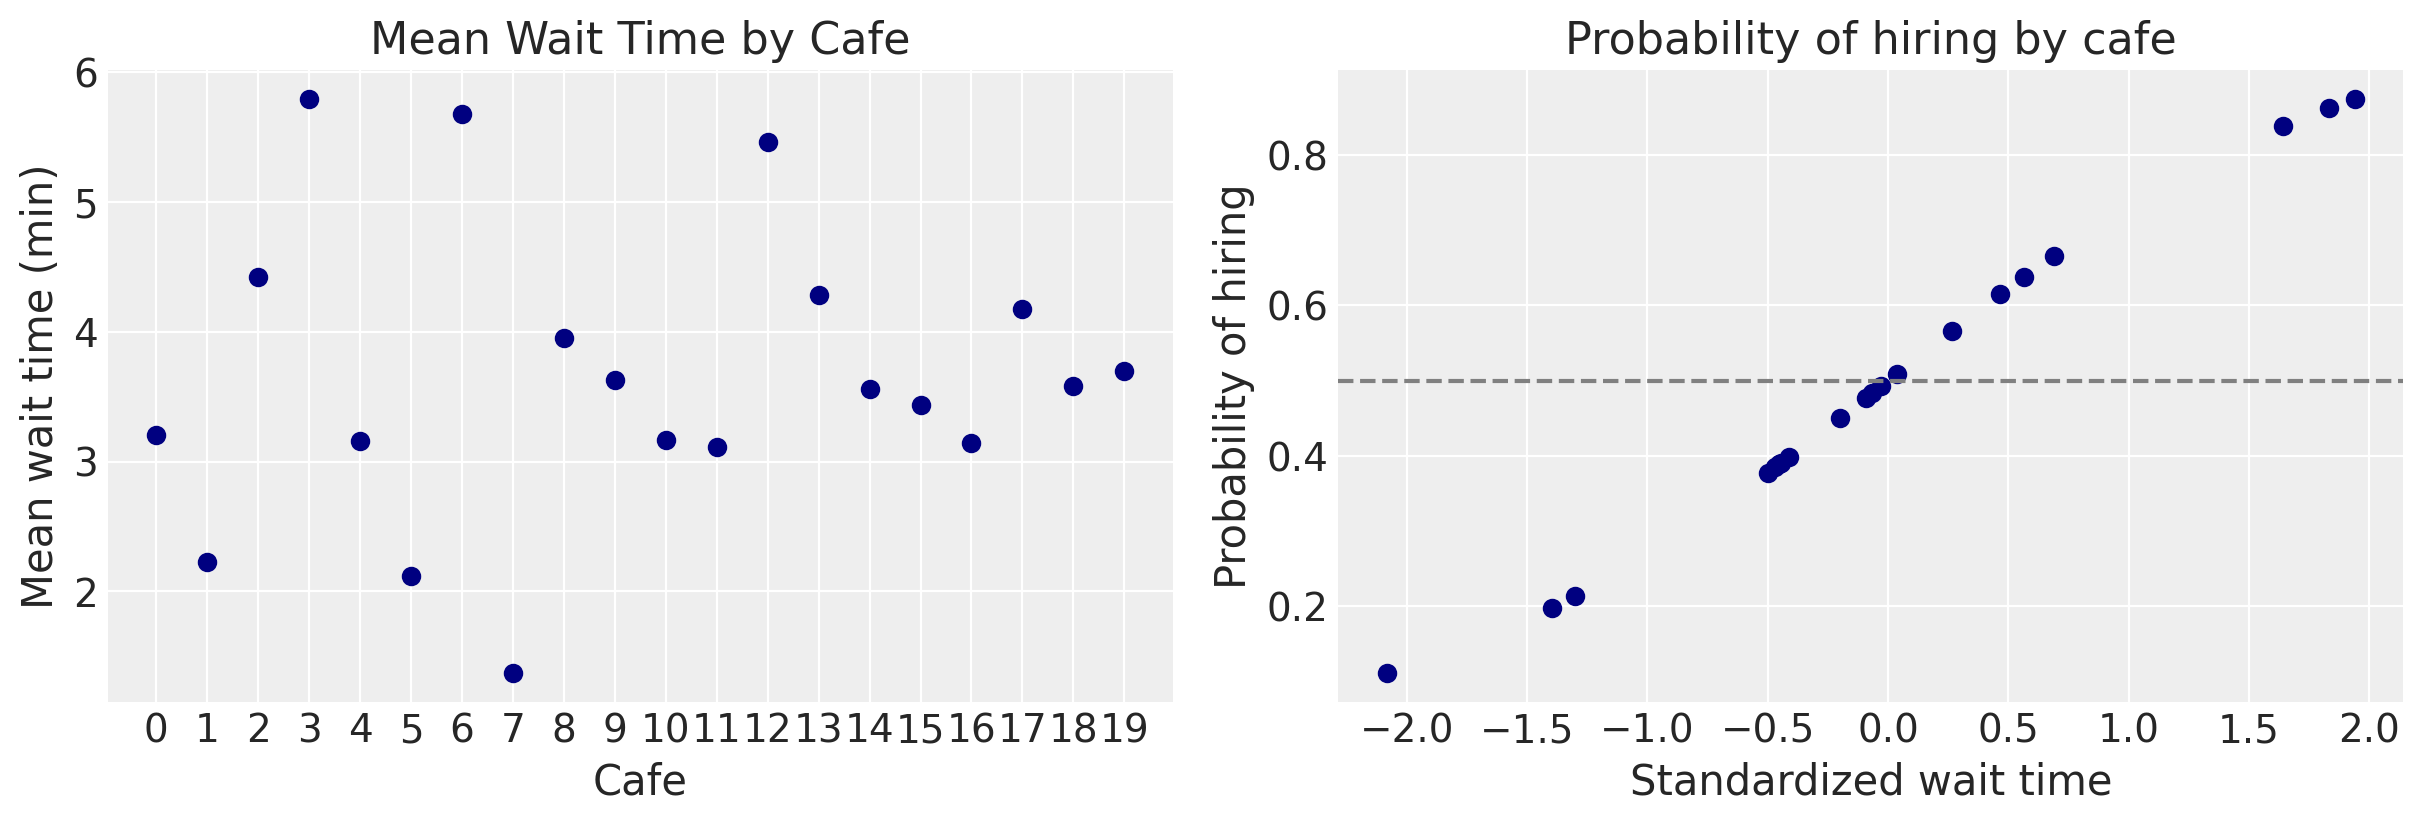

<IPython.core.display.Javascript object>

In [31]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4))
ax0.scatter(range(len(df_cafes)), df_cafes['wait_time_raw'], color='navy')
ax0.set(xlabel='Cafe', ylabel='Mean wait time (min)', title='Mean Wait Time by Cafe')
ax0.set_xticks(range(len(df_cafes)))
ax0.set_xticklabels(df_cafes.index)

ax1.scatter( df_cafes['wait_time_std'], df_cafes['prob_hire'], color='navy')
ax1.axhline(0.5, color='gray', linestyle='--')
ax1.set(xlabel='Standardized wait time', ylabel='Probability of hiring', title='Probability of hiring by cafe')

Another way that we can generate data, however, is to use all of the uncertainty of a prior and generate prior predictive simulations. This means that instead of assigning an arbitrary value for $\bar{\alpha}$ and $\sigma_{\alpha}$, we would draw samples from their respective distributions.

In [17]:
# These arbitrary values were taken from SR Chapter 14

N_cafe = 20                              # number of cafes

# Generate distributions for each cafe
n = 10**4                                # number of draws from the sample distribution
a_cafes_dist = np.zeros((N_cafe, n))     # initialize an array to hold the distributions

for i in range(N_cafe):
    sigma_a = stats.expon.rvs(scale=1/1, size=1)    # scipy.stats.exp uses lambda as scale = 1/lambda
    a_bar = stats.norm.rvs(loc=0, scale=1.5, size=1)
    a_cafes_dist[i, :] = stats.norm.rvs(loc=a_bar, scale=sigma_a, size=n)
    
print(f"shape of array: {a_cafes_dist.shape}")

shape of array: (20, 10000)


<IPython.core.display.Javascript object>

In [18]:
pd.DataFrame(
    {"means of each cafe" : np.mean(a_cafes_dist, axis=1),
    "SD of each cafe" : np.std(a_cafes_dist, axis=1),
    "89% HDI of each cafe" : [np.around(az.hdi(a_cafes_dist[i, :]), 3) for i in range(N_cafe)]}
)

,means of each cafe,SD of each cafe,89% HDI of each cafe
0,-0.350361,0.334972,"[-0.883, 0.191]"
1,0.628600,0.096433,"[0.482, 0.786]"
2,-1.778195,2.163814,"[-5.187, 1.752]"
3,0.921150,0.007026,"[0.91, 0.932]"
4,1.242083,1.219753,"[-0.742, 3.118]"
5,0.115650,3.978669,"[-6.079, 6.576]"
6,-0.587596,0.752071,"[-1.879, 0.527]"
7,-0.904908,3.852350,"[-7.005, 5.254]"
8,-0.069641,0.970740,"[-1.614, 1.47]"
9,0.063069,1.244860,"[-1.894, 2.088]"


<IPython.core.display.Javascript object>

### Varying effects

Here we'll demonstrate varying effects, specifically varying effects that are correlated. Rather than have one term that exhibits partial pooling we have two and those two variables have an implied covariance. Our covariance will be between the $\bar{\alpha}$ and $\bar{\beta}$ terms, represented in code by `a_bar` and `b_bar`, respectively. By expressing this covariance in a multivariate normal distribution, we can enable partial pooling between these parameters. This increases the accuracy of estimates in a statistical model than if partial pooling for those variables were separate. Here is the multi-variate normal equation again.

$$ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right) $$

As we did in the varying intercepts model, let's generate data with these assumptions before running a statistical model. We'll input arbitrary values.

In [46]:
N_cafe = 20         # number of cafes
a_bar = 3.5  # average morning wait time
b_bar = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

# assemble the mean vector
Mu = np.array([a_bar, b_bar])
# assemble the covariance matrix
Sigma = np.array([[sigma_a**2, rho*sigma_a*sigma_b],
                    [rho*sigma_a*sigma_b, sigma_b**2]])
            
# Generate samples for each cafe
mu_ve_dist = stats.multivariate_normal.rvs(mean=Mu, cov=Sigma, size=N_cafe)
mu_ve_dist

array([[ 4.87644665, -0.89882531],
       [ 2.12310912, -0.50554675],
       [ 3.2057185 , -1.52690789],
       [ 2.85547036, -1.0208212 ],
       [ 3.82947004, -1.1957314 ],
       [ 5.23857535, -1.85670929],
       [ 4.53051121, -2.15785539],
       [ 2.35994885, -0.64298119],
       [ 3.30597697, -0.67167042],
       [ 4.24684273, -1.0828668 ],
       [ 4.37426169, -1.37812892],
       [ 3.37484095, -0.64047199],
       [ 3.48374163, -0.73734846],
       [ 1.38726766,  0.09291514],
       [ 4.27584065, -1.37818867],
       [ 4.24786672, -1.5310328 ],
       [ 3.32977647, -0.98849569],
       [ 3.61445174, -1.03273259],
       [ 4.1807666 , -1.57206684],
       [ 2.24170295, -0.93262335]])

<IPython.core.display.Javascript object>

This time, each draw from our sample distribution (representing each hypothetical cafe) contains two values, the mean wait time and the coefficient for wait time when we are looking at the afternoon ($A=1$). When we take the inverse logit of the afternoon wait time, we can think of our data now as the probability of a cafe hiring another worker for the afternoon shift.

In [47]:
pm_wait_time = mu_ve_dist[:, 0] + mu_ve_dist[:, 1]
wait_time_pm_std = standardize(pm_wait_time)
prob_pm_hire = expit(wait_time_pm_std)

df_cafes_pm = pd.DataFrame(
    {
        "wait_time_raw_pm": pm_wait_time,
        "wait_time_pm_std": wait_time_pm_std,
        "prob_pm_hire": prob_pm_hire,
    }
)

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'Standardized wait time'),
 Text(0, 0.5, 'Probability of hiring\n(pm shift)'),
 Text(0.5, 1.0, 'Probability of hiring by cafe\n(afternoon shift)')]

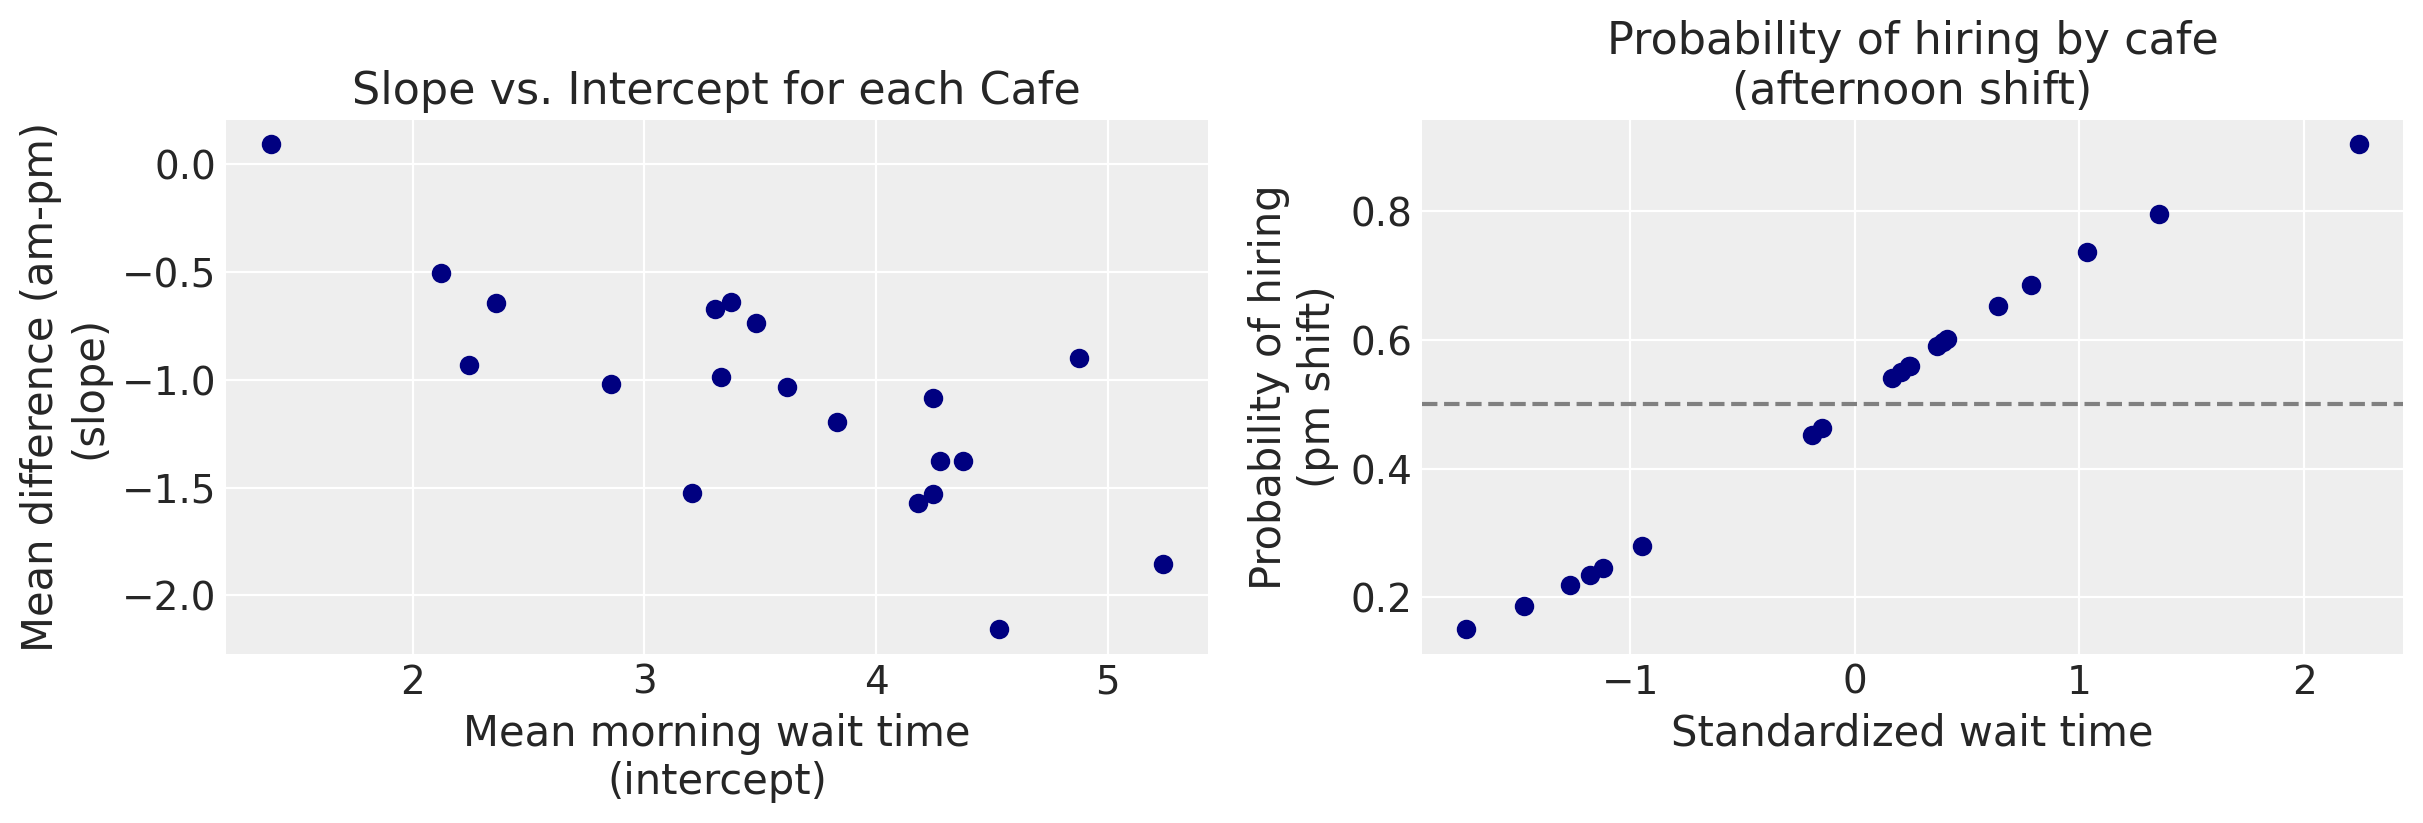

<IPython.core.display.Javascript object>

In [48]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4))
ax0.scatter(mu_ve_dist[:, 0], mu_ve_dist[:, 1], c='navy')
ax0.set(xlabel='Mean morning wait time\n(intercept)', ylabel='Mean difference (am-pm)\n(slope)', title='Slope vs. Intercept for each Cafe')

ax1.scatter( df_cafes_pm['wait_time_pm_std'], df_cafes_pm['prob_pm_hire'], color='navy')
ax1.axhline(0.5, color='gray', linestyle='--')
ax1.set(xlabel='Standardized wait time', ylabel='Probability of hiring\n(pm shift)', title='Probability of hiring by cafe\n(afternoon shift)')

## Inferential model

Now that we've generated the data, let's see if we can correctly build models that recover the parameters. We'll still think in terms of centered paramaterizations here and look at both the varying intercepts and varying effects examples.

We can look directly at the equations side-by-side to see how the parameters between varying intercepts and varying effects compare.

<center>

**Centered paramaterization**  

|  | varying intercepts | varying effects|
| -- | -- | -- | 
| likelihood | $ H_i \sim \text{Bernoulli}(p_i) $  | $ H_i \sim \text{Bernoulli}(p_i) $  |
| linear model | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} $  | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]}A_i $  |
| adaptive prior for each cafe | $ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| hyperprior for average cafe | $ \bar{\alpha} \sim \text{Normal}(0, 1.5) $  | $ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 1.5) $   |
| hyperprior for SD of cafe | $ \sigma_{\alpha} \sim \text{Exp}(1) $  | $ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $   |
| hyperprior for correlation matrix | n/a | $ \text{LKJCorr}(2) $   |


</center>

### Varying intercepts

In [78]:
df_cafes.head()

,wait_time_raw,wait_time_std,prob_hire,hire
0,2.998266,-0.355329,0.412091,0.0
1,2.199842,-1.135975,0.243060,0.0
2,2.816503,-0.533045,0.369807,0.0
3,3.737258,0.367209,0.590784,1.0
4,3.897256,0.523644,0.627999,1.0


<IPython.core.display.Javascript object>

In [79]:
with pm.Model() as mVIc:

    # prior for average cafe wait time
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of cafe wait time
    sigma_a = pm.Exponential("sigma", 1.0)

    # alpha priors for each cafe wait time
    a = pm.Normal("a", a_bar, sigma_a, shape=len(df_cafes.index))

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a[df_cafes.index]))

    # likelihood, n=1 since each represents an individual woman
    h = pm.Bernoulli("h", p=p, observed=df_cafes["hire"])

    trace_mVIc = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6344575742942721, but should be close to 0.8. Try to increase the number of tuning steps.
There were 867 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 3.0873579900753985e-12, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.484100177114286, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match

<IPython.core.display.Javascript object>

In [81]:
az.summary(trace_mVIc, var_names=['a_bar', 'sigma', 'a'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.239,0.611,-1.050,0.717,0.144,0.103,18.0,18.0,21.0,173.0,1.13
sigma,1.007,1.045,0.172,2.320,0.256,0.184,17.0,17.0,7.0,4.0,1.64
a[0],-0.625,1.480,-2.709,0.993,0.229,0.163,42.0,42.0,26.0,298.0,1.55
a[1],-0.687,1.401,-2.597,1.111,0.147,0.104,91.0,91.0,49.0,464.0,1.54
a[2],-0.641,1.516,-2.608,1.134,0.215,0.153,50.0,50.0,38.0,386.0,1.54
a[3],0.282,1.526,-1.302,2.480,0.242,0.173,40.0,40.0,25.0,407.0,1.12
a[4],0.329,1.382,-1.268,2.265,0.219,0.156,40.0,40.0,29.0,255.0,1.10
a[5],-0.655,1.335,-2.351,1.281,0.165,0.117,65.0,65.0,48.0,312.0,1.55
a[6],0.348,1.456,-1.468,2.201,0.178,0.126,67.0,67.0,51.0,245.0,1.07
a[7],0.297,1.422,-1.239,2.232,0.238,0.169,36.0,36.0,23.0,355.0,1.13


<IPython.core.display.Javascript object>

Yikes. This didn't sample well at all. But this will help us illustrate the point that non-centered parameterizations can do better.

# Non-centered paramaterization


<center>

**Centered paramaterization**  

|  | varying intercepts | varying effects|
| -- | -- | -- | 
| likelihood | $ H_i \sim \text{Bernoulli}(p_i) $  | $ H_i \sim \text{Bernoulli}(p_i) $  |
| linear model | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} $  | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]}A_i $  |
| adaptive prior for each cafe | $ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| hyperprior for average cafe | $ \bar{\alpha} \sim \text{Normal}(0, 1.5) $  | $ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 1.5) $   |
| hyperprior for SD of cafe | $ \sigma_{\alpha} \sim \text{Exp}(1) $  | $ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $   |
| hyperprior for correlation matrix | n/a | $ \text{LKJCorr}(2) $   |

<br>
<br>

**Non-centered paramaterization**  

|  | varying intercepts | varying effects|
| -- | -- | -- | 
| likelihood | $ H_i \sim \text{Bernoulli}(p_i) $  | $ H_i \sim \text{Bernoulli}(p_i) $  |
| linear model | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} $  | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]}A_i $  |
| adaptive prior (deterministic) | $ \alpha_j = \bar{\alpha} + z \times \sigma_{\alpha} $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| random variable | $ z_j \sim \text{Normal}(0, 1) $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| hyperprior for average cafe | $ \bar{\alpha} \sim \text{Normal}(0, 1.5) $  | $ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 1.5) $   |
| hyperprior for SD of cafe | $ \sigma_{\alpha} \sim \text{Exp}(1) $  | $ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $   |
| hyperprior for correlation matrix | n/a | $ \text{LKJCorr}(2) $   |



</center>


$$ \alpha_j = \bar{\alpha} + z \times \sigma_{\alpha} $$ 
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ z \sim \text{Normal}(0, 1) $$
$$ \sigma \sim \text{Exponential}(1) $$

In [83]:
with pm.Model() as mVInc:

    # prior for average cafe wait time
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of cafe wait time
    sigma_a = pm.Exponential("sigma", 1.0)
    
    # random variable to improve sampling
    z = pm.Normal("z", 0.0, 1.0, shape=len(df_cafes.index))

    # a results from a deterministic relationship
    a = pm.Deterministic("a", a_bar + z * sigma_a)

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a[df_cafes.index]))

    # likelihood, n=1 since each represents an individual woman
    h = pm.Bernoulli("h", p=p, observed=df_cafes["hire"])

    trace_mVInc = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [89]:
df_summary_mVInc = az.summary(trace_mVInc, var_names=['a'])
df_summary_mVInc

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.893,1.600,-2.964,1.221,0.045,0.032,1272.0,1272.0,1477.0,1525.0,1.0
a[1],-0.932,1.744,-3.351,1.117,0.047,0.034,1391.0,1295.0,1741.0,1488.0,1.0
a[2],-0.903,1.736,-2.963,1.300,0.045,0.032,1506.0,1506.0,1822.0,1572.0,1.0
a[3],0.541,1.767,-1.742,2.802,0.051,0.038,1204.0,1074.0,1703.0,1300.0,1.0
a[4],0.533,1.714,-1.607,2.720,0.046,0.032,1400.0,1400.0,1792.0,1407.0,1.0
a[5],-0.885,1.633,-3.011,1.239,0.049,0.035,1092.0,1092.0,1407.0,1090.0,1.0
a[6],0.506,1.534,-1.625,2.590,0.037,0.026,1690.0,1690.0,1942.0,2077.0,1.0
a[7],0.572,1.758,-1.397,2.851,0.050,0.038,1252.0,1060.0,1714.0,1578.0,1.0
a[8],0.477,1.526,-1.420,2.613,0.039,0.028,1496.0,1496.0,1730.0,1952.0,1.0
a[9],-0.897,1.722,-3.204,1.004,0.054,0.039,1032.0,972.0,1584.0,1352.0,1.0


<IPython.core.display.Javascript object>

This sampled much better. Let's look at our estimates.

In [87]:
df_cafes.head()

,wait_time_raw,wait_time_std,prob_hire,hire
0,2.998266,-0.355329,0.412091,0.0
1,2.199842,-1.135975,0.243060,0.0
2,2.816503,-0.533045,0.369807,0.0
3,3.737258,0.367209,0.590784,1.0
4,3.897256,0.523644,0.627999,1.0


<IPython.core.display.Javascript object>

In [93]:
df_summary_mVInc['mean']

a[0]    -0.893
a[1]    -0.932
a[2]    -0.903
a[3]     0.541
a[4]     0.533
a[5]    -0.885
a[6]     0.506
a[7]     0.572
a[8]     0.477
a[9]    -0.897
a[10]    0.454
a[11]   -0.884
a[12]    0.535
a[13]   -0.900
a[14]   -0.904
a[15]    0.500
a[16]    0.560
a[17]   -0.902
a[18]   -0.896
a[19]   -0.902
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

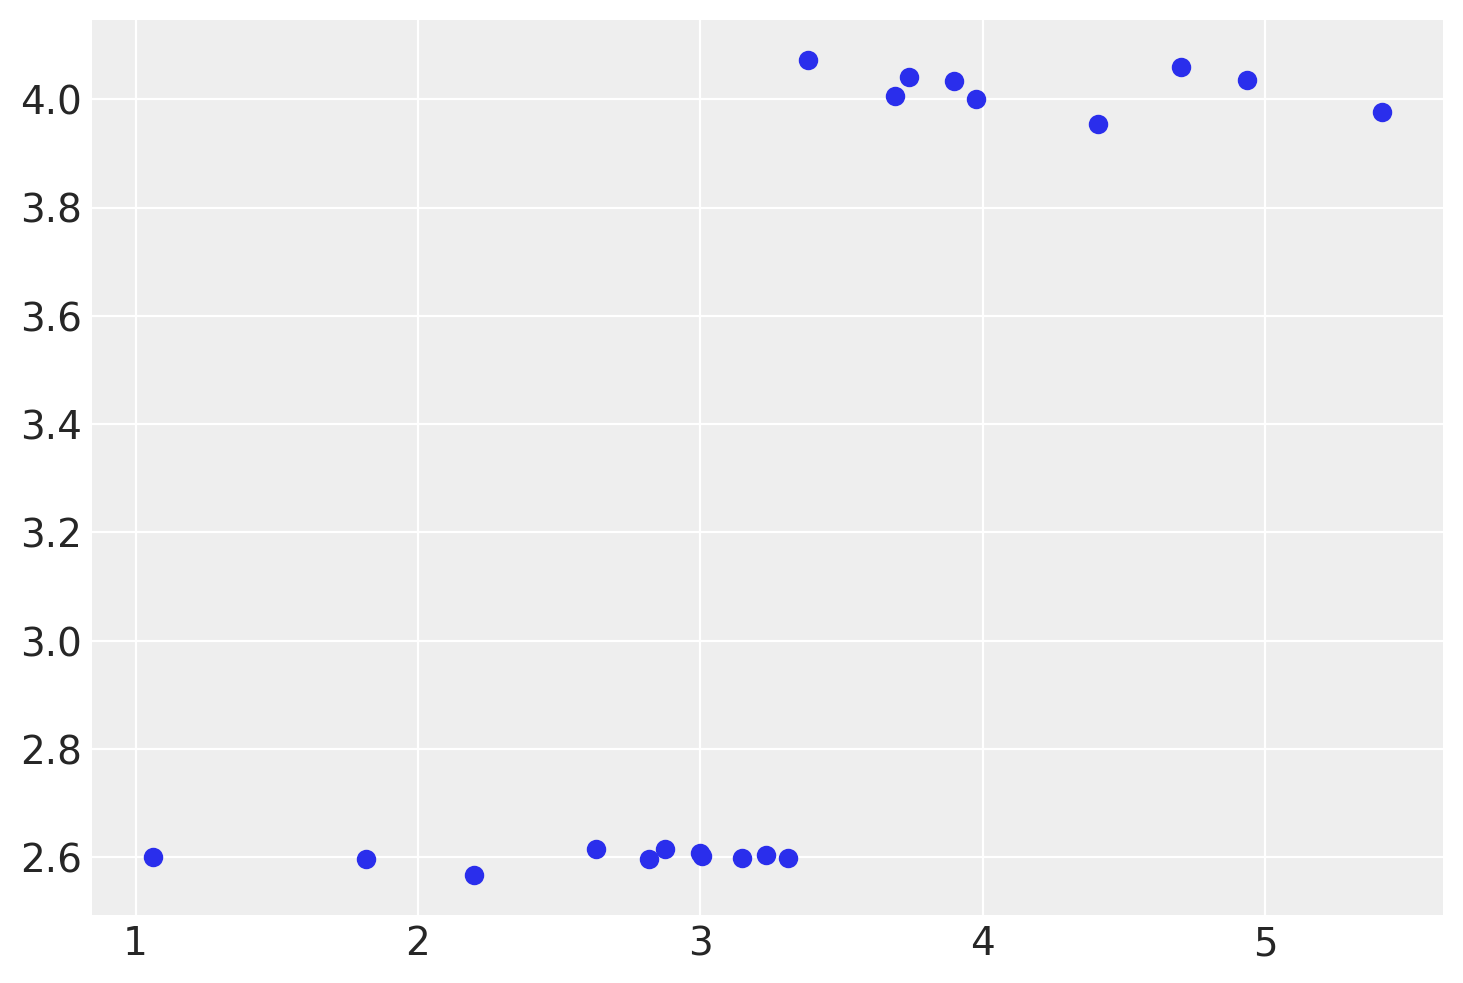

<IPython.core.display.Javascript object>

In [103]:
f, ax0 = plt.subplots()
ax0.scatter(df_cafes['wait_time_raw'], (df_summary_mVInc['mean'] * sigma_a) + a_bar)

In [100]:
(a-abar)/sd = (astd * sd) + abar

SyntaxError: cannot assign to operator (<ipython-input-100-698da1420548>, line 1)

<IPython.core.display.Javascript object>

In [101]:
(df_cafes['wait_time_std'] * sigma_a) + a_bar

0     3.144671
1     2.364025
2     2.966955
3     3.867209
4     4.023644
5     2.784211
6     3.821069
7     3.518674
8     5.506180
9     3.150718
10    4.521975
11    3.024070
12    5.039953
13    1.251633
14    1.988164
15    4.102035
16    4.811235
17    3.449196
18    3.375170
19    3.289214
Name: wait_time_std, dtype: float64

<IPython.core.display.Javascript object>

In [98]:
sigma_a = 1.0  # std dev in intercepts
a_bar = 3.5  

<IPython.core.display.Javascript object>

In [99]:
a_bar

3.5

<IPython.core.display.Javascript object>

# Appendix

In [45]:
%watermark -n -u -v -iv -w

Last updated: Sat Apr 02 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

matplotlib: 3.3.4
pandas    : 1.2.1
arviz     : 0.11.1
sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
scipy     : 1.6.0
seaborn   : 0.11.1
numpy     : 1.20.1
theano    : 1.1.0
pymc3     : 3.11.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>